In [1]:
import allensdk
allensdk.__file__

'D:\\Anaconda3\\lib\\site-packages\\allensdk\\__init__.py'

In [3]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
pd.set_option("display.max_columns", None)

import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

from tqdm import tqdm  # from tqdm.notebook import trange
import time

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_model
import hierarchical_sampling_model
import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [231]:
import allensdk
import h5py
import pynwb
import hdmf
import pandas
print('pandas', pandas.__version__)
print('allensdk', allensdk.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)

pandas 1.1.1
allensdk 2.2.0
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0


You need to modify AllenSDK package to change download time to fully download the large data.

In [5]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Download time: 720000


In [6]:
session_id = 757216464  # 757216464 798911424 760345702 
session = cache.get_session_data(session_id)

# Extract data from multiple brain areas

### Check areas.

In [115]:
all_areas_map = session.map_probe_to_ecephys_structure_acronym(visual_only=False, verbose=True)
vis_areas_map = session.map_probe_to_ecephys_structure_acronym(visual_only=True, verbose=True)

----------- All recorded regions by probe ----------
probeA: ['MRN' 'MB' 'APN' 'NOT' 'CA1' 'VISam']
probeB: ['Eth' 'TH' 'APN' 'DG' 'CA1' 'VIS']
probeC: ['MGm' 'SGN' 'LP' 'DG' 'ProS' 'SUB' 'VISp']
probeD: ['LGv' 'CA3' 'DG' 'CA1' 'VISl']
probeE: ['PO' 'LP' 'LGd' 'CA3' 'DG' 'CA1' 'VISal']
probeF: ['LP' 'DG' 'CA1' 'VISrl']
----------- Only visual ----------
probeA: ['VISam']
probeB: ['VIS']
probeC: ['VISp']
probeD: ['VISl']
probeE: ['VISal']
probeF: ['VISrl']


### Neurons Selection

In [8]:
probes = ['probeC', 'probeD', 'probeE']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) &
    session.units['probe_description'].isin(probes)]
display(selected_units['probe_description'].value_counts())
display(selected_units['probe_description'].count())

probeC    85
probeD    53
probeE    53
Name: probe_description, dtype: int64

191

## Trials Selection

In [204]:
condition_ids = [275, 277, 246, 255, 272, 248, 283, 266, 274, 276, 286, 271, 268, 270]   # x14 757216464

stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(condition_ids)]
all_trials_indices = trials_df.index.values
trials_groups = trials_df.groupby('stimulus_condition_id')
all_condition_ids = list(trials_groups.groups.keys())
hierarchical_sampling_model.HierarchicalSamplingModel.print_conditions(trials_groups)

0  246 temp freq [1.0] orient [90.0] contrast [0.8] [ 3798  3887  3932  3936  3946 31018 31019 31024 31041 31130 31158 31199 49246 49261 49316]
1  248 temp freq [8.0] orient [90.0] contrast [0.8] [ 3800  3809  3877  3879  3899  3929 31015 31073 31100 49304 49362 49389 49400 49408 49423]
2  255 temp freq [2.0] orient [90.0] contrast [0.8] [ 3810  3886  3940  3996 31020 31037 31040 31065 31110 31200 49241 49288 49340 49355 49373]
3  266 temp freq [15.0] orient [180.0] contrast [0.8] [ 3824  3831  3847  3855  3857  3858  3921  3945  3949 31013 31055 31062 31194 49218 49244]
4  268 temp freq [15.0] orient [270.0] contrast [0.8] [ 3827  3834  3866  3951 31011 31050 31119 31124 31138 31166 49233 49249 49335 49365 49376]
5  270 temp freq [8.0] orient [315.0] contrast [0.8] [ 3830  3836  3983  3987 31032 31105 31143 31188 49204 49262 49302 49367 49391 49392 49428]
6  271 temp freq [8.0] orient [270.0] contrast [0.8] [ 3832  3873  3933  3970  3997 31023 31104 31136 31183 49208 49227 49286 49364

## Load Spike Trains

In [205]:
data_loader = data_model.AllenInstituteDataModel(session)
trial_time_window=[0.0, 0.5]
dt=0.002
spike_train_time_line = np.arange(trial_time_window[0], trial_time_window[1], dt)

spike_trains = data_loader.get_trial_metric_per_unit_per_trial(
    stimulus_presentation_ids=all_trials_indices,
    unit_ids=selected_units.index.values,
    trial_time_window=trial_time_window,
    metric_type='spike_trains', dt=dt)

spike_times = data_loader.get_trial_metric_per_unit_per_trial(
        stimulus_presentation_ids=all_trials_indices,
        unit_ids=selected_units.index.values,
        trial_time_window=trial_time_window,
        metric_type='spike_times')

display(spike_trains.shape)
# display(spike_trains.head())
display(spike_times.shape)
# display(spike_times.head())

(191, 210)

(191, 210)

# Initialization and training

In [206]:
np.random.seed(0)
model = hierarchical_sampling_model.HierarchicalSamplingModel(session)
model.initial_step(spike_trains, spike_times, spike_train_time_line, selected_units, trials_groups, 
                   trial_time_window, probes=['probeC', 'probeD', 'probeE'], num_areas=3, num_groups=3,
                   model_feature_type='BSS', prior_type='diag', eta_smooth_tuning=3e-8, verbose=False)

experiment_folder = f'{session_id}_condition{len(condition_ids)}_{time.strftime("%Y%m%d-%H%M%S")}'
batches_dir = project_dir + 'Output/models/'

Model feature type:  BSS
Condition: 0  stimulus_condition_id:246
probeC g:[2 1 0] counts:[34 30 21]  probeD g:[2 1 0] counts:[21 19 13]  probeE g:[2 1 0] counts:[21 19 13]  
Condition: 1  stimulus_condition_id:248
probeC g:[2 1 0] counts:[34 31 20]  probeD g:[2 1 0] counts:[21 19 13]  probeE g:[2 1 0] counts:[21 20 12]  
Condition: 2  stimulus_condition_id:255
probeC g:[2 1 0] counts:[34 30 21]  probeD g:[2 1 0] counts:[21 19 13]  probeE g:[2 1 0] counts:[21 19 13]  
Condition: 3  stimulus_condition_id:266
probeC g:[2 1 0] counts:[34 30 21]  probeD g:[2 1 0] counts:[21 19 13]  probeE g:[2 1 0] counts:[21 19 13]  
Condition: 4  stimulus_condition_id:268
probeC g:[2 1 0] counts:[36 29 20]  probeD g:[2 1 0] counts:[21 19 13]  probeE g:[2 1 0] counts:[22 18 13]  
Condition: 5  stimulus_condition_id:270
probeC g:[2 1 0] counts:[35 30 20]  probeD g:[2 1 0] counts:[22 18 13]  probeE g:[2 1 0] counts:[22 18 13]  
Condition: 6  stimulus_condition_id:271
probeC g:[2 1 0] counts:[37 27 21]  probe

In [208]:
clist = list(range(len(condition_ids)))

trange = tqdm(range(0, 8000), ncols=100, file=sys.stdout)
for itr in trange:
    for c in clist:
        if itr < 150:
            model.update_f_local_pop_cag(c, sample_type='fit', verbose=False)
            model.update_f_cross_pop_ca(c, sample_type='fit', record=(c==clist[-1]), verbose=False)
        elif itr >= 150:
            model.update_f_local_pop_cag(c, sample_type='sample', verbose=False)
            model.update_f_cross_pop_ca(c, sample_type='sample', record=(c==clist[-1]), verbose=False)
        if itr < 15:
            model.update_q_arc(c, sample_type='fit', fit_peak_ratio=0,
                               record=(c==clist[-1]), verbose=False)
        elif (itr >= 15) and (itr < 30):  # Fit with peak.
            model.update_q_arc(c, sample_type='fit', fit_peak_ratio=0.05, 
                               record=(c==clist[-1]), verbose=False)
        elif itr >= 30:
            model.update_q_arc(c, sample_type='sample', proposal_scalar=0.015, fit_peak_ratio=0,
                               record=(c==clist[-1]), verbose=False)
        if itr >= 80:
            model.update_z_ngac(c, sample_type='sample',
                                record=(c==clist[-1]), verbose=False)
            model.update_p_gac(c, sample_type='sample',
                               record=(c==clist[-1]), verbose=False)
    if itr > 60:
        model.update_mu_simga(clist=clist, sample_type='iw_sample', verbose=False)

    model.complete_log_likelihood(clist)
    trange.set_description(f'{model.samples.log_likelihood[-1]:.2f} | {model.samples.q_accept_ratio_mean:.3f}')
    model.recorder(itr, batches_dir, experiment_folder, batch_size=500)


-571642.12 | 0.351: 100%|████████████████████████████████████| 8000/8000 [17:12:10<00:00,  7.74s/it]


# Load trained model and samples batches
After training, the buffer will be empty as samples are saved in batches. You need to reload the model or samples.

In [210]:
model = hierarchical_sampling_model.HierarchicalSamplingModel(session, empty_samples=True)
model_dir = project_dir + '/Output/models/757216464_BSS_MC_0_500ms_probeCDE_condition14_diag_prior_alpha5_20210928-094617/'
model_file0 = model_dir + '757216464_checkpoints_batch0_20210928-110035.pkl'  # First batch.
model_file1 = model_dir + '757216464_checkpoints_batch15_20210929-025828.pkl'  # Last batch.
model.load_model(model_file0); model.load_model(model_file1)

In [ ]:
model.samples.load_batches(model_dir, start_id=0, end_id=15, thin_step=1)

# Results

The sample sizes of differet variables are slightly different as some were fixed during initial traning. 
But the samples are used after they are aligned.

In [212]:
model.samples.peek()

f_pop:8000  f_pop_beta:8000  q:8000  q_shift1:8000  q_shift2:8000  f_warp_sources:8000  f_warp_targets:8000  mu_cross_pop:7939  sigma_cross_pop:7939  rho_cross_pop_simple:7939  z:7920  p:7920  log_likelihood:8000  


In [ ]:
model.samples.plot_log_likelihood()

## Instantaneous activities $f^{\text{pop}}$, $f^{\text{local}}$

In [ ]:
clist = list(range(len(condition_ids)))
model.samples.plot_f_pop_rainbow(clist, spike_train_time_line, burn_in=2000, end=None, step=100, condition_ids=all_condition_ids,
                                 f_peak1_ac_ref=model.f_peak1_ac, f_peak2_ac_ref=model.f_peak2_ac)

f_samples.shape: (120, 14, 3, 3, 250)
Save figure: D:/Brain_Network/Output/fig/757216464_f_pop.pdf


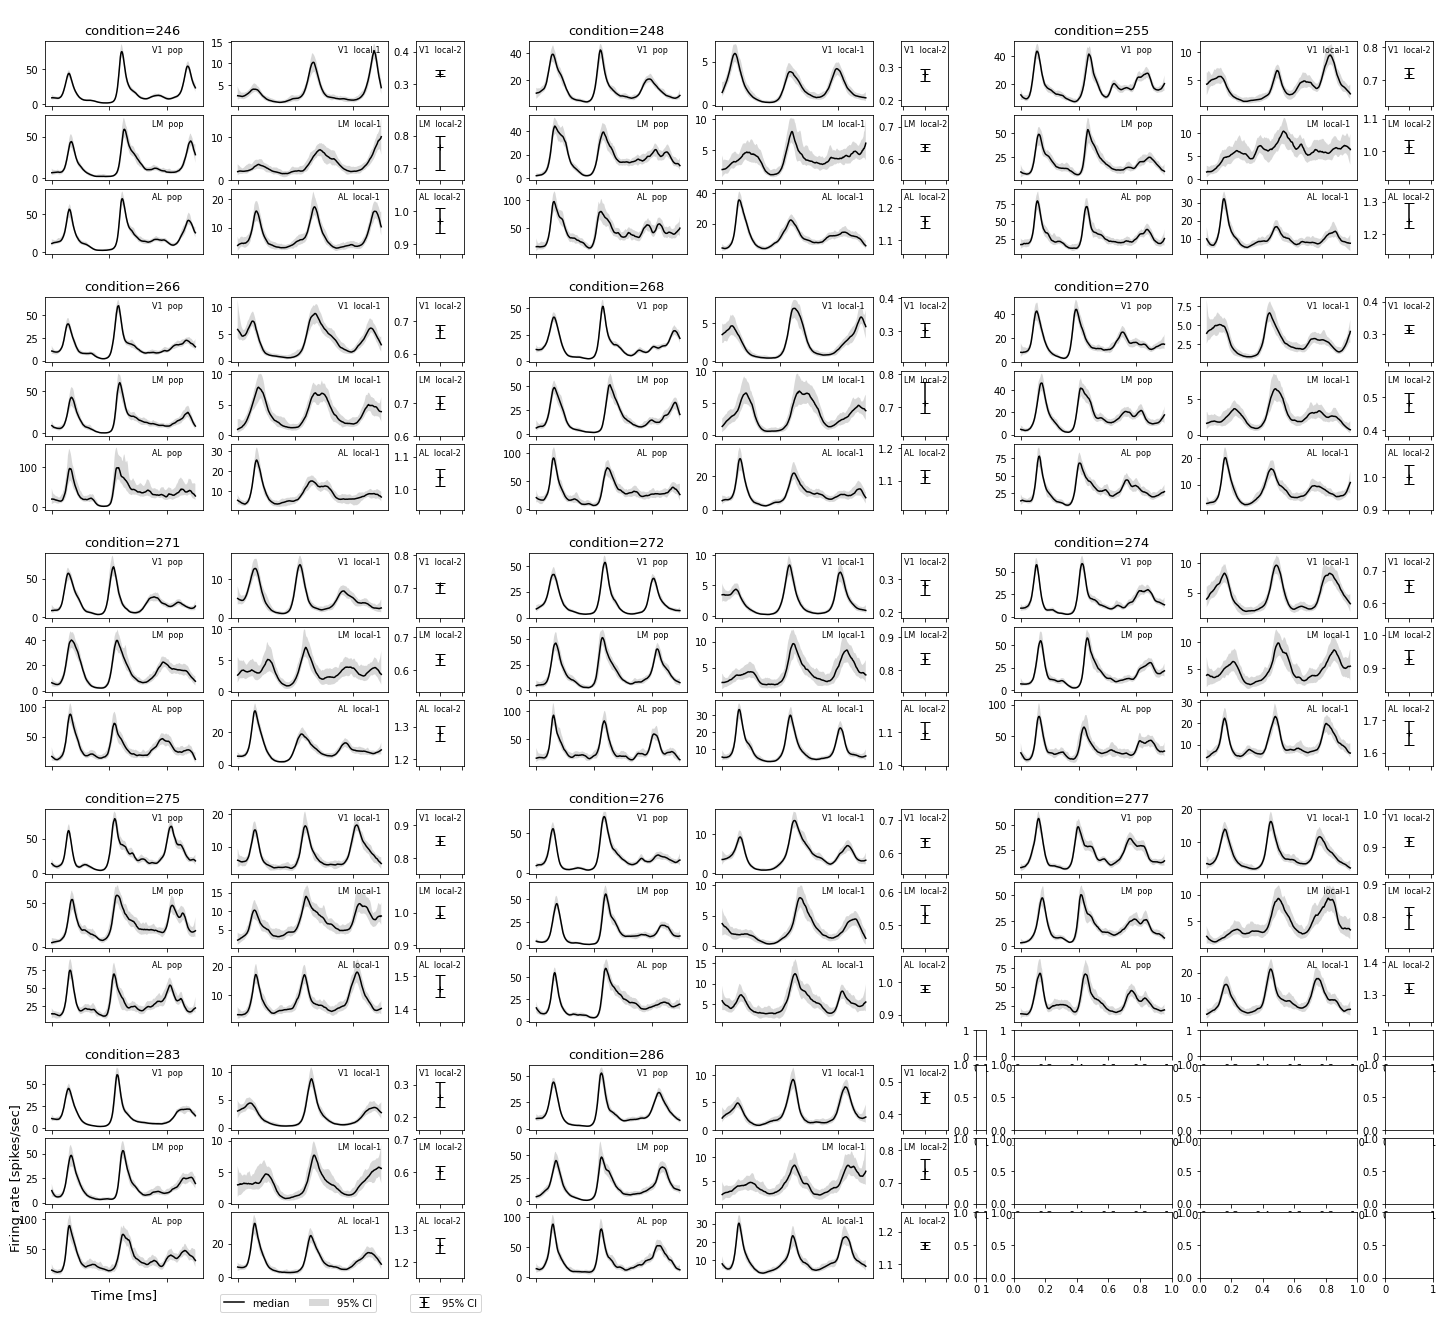

In [215]:
output_dir = f'D:/Brain_Network/Output/fig/'
clist = list(range(len(condition_ids)))
model.samples.plot_f_pop_CI(clist, spike_train_time_line, burn_in=2000, end=None, step=50,
                            condition_ids=all_condition_ids, show_legend=True, output_dir=output_dir)

Save figure to:  D:/Brain_Network/Output/fig/757216464_t3951_trial_demo.pdf


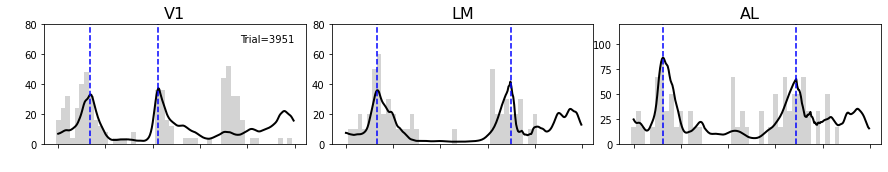

Save figure to:  D:/Brain_Network/Output/fig/757216464_t3951_trial_phi_demo.pdf


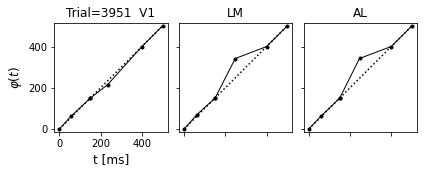

In [217]:
output_dir = f'D:/Brain_Network/Output/fig/'
model.plot_group_activity_per_trial_demo(c=4, r=3, show_label=False, show_warp=True, ylims=[80, 80, 120], output_dir=output_dir)

#### Cross-validation

In [ ]:
tuning_par_list = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 2e-8, 3e-8, 4e-8, 5e-8, 8e-8, 1e-7, 1e-6]
nll_cv_train, nll_cv_test = model.eta_smoothing_cross_validation(tuning_par_list, num_fold=5, include_non_cross_groups=False, verbose=False)

In [ ]:
plt.figure(figsize=[5, 2])
mean = nll_cv_train.mean(axis=1)
mse = nll_cv_train.std(axis=1) / np.sqrt(nll_cv_train.shape[1])

mean = nll_cv_test.mean(axis=1)
mse = nll_cv_test.std(axis=1) / np.sqrt(nll_cv_test.shape[1])
plt.plot(tuning_par_list, mean, 'k.-')
# plt.plot(tuning_par_list, mean + mse, 'k:')
# plt.plot(tuning_par_list, mean - mse, 'k:')
plt.xscale('log')
plt.show()

## Peaks

In [ ]:
output_dir = f'D:/Brain_Network/Output/fig/'
clist = list(range(len(condition_ids)))
model.samples.plot_lead_lag_CI(clist, spike_train_time_line, fit_type='refine',
                               burn_in=2000, end=None, step=50, verbose=False, output_dir=output_dir)

sources.shape: (100, 3, 15, 14, 6)
targets.shape: (100, 3, 15, 14, 6)
f_pop.shape: (100, 14, 3, 3, 250)
peak1_acrs.shape: (3, 14, 15, 100)
peak1_ar.shape: (3, 210)
peak2_ar.shape: (3, 210)
save figure: D:/Brain_Network/Output/fig/peak_1_distribution.pdf


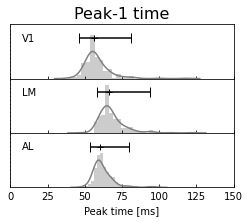

save figure: D:/Brain_Network/Output/fig/peak_2_distribution.pdf


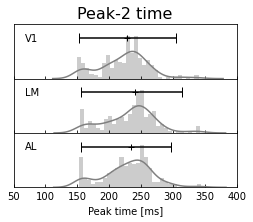

In [219]:
output_dir = 'D:/Brain_Network/Output/fig/'
clist = list(range(len(condition_ids)))
model.samples.plot_peak_distribution(clist, spike_train_time_line, fit_type='refine',
                                     burn_in=3000, end=None, step=50, output_dir=output_dir, verbose=False)

## Feature correlation & partial correlations

sigma_samples.shape: (7939, 9, 9)
save figure: D:/Brain_Network/Output/fig/757216464_marginal_corr_CI_hist.pdf


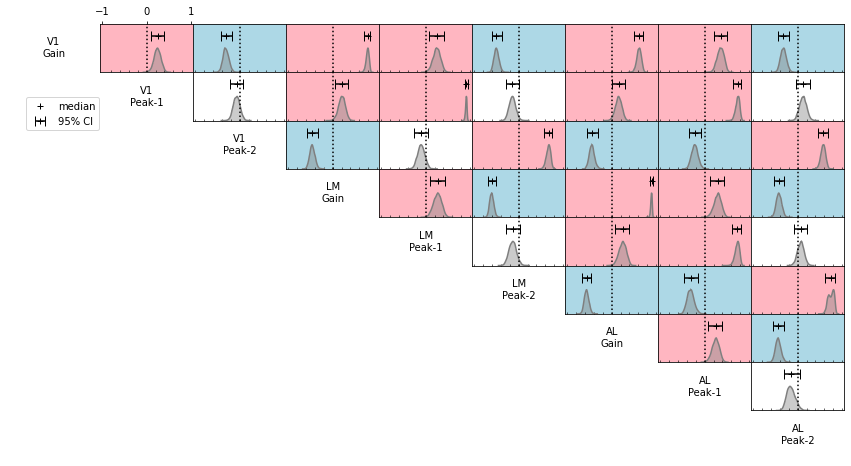

In [220]:
output_dir = 'D:/Brain_Network/Output/fig/'
marginal_adj, marginal_adj2, marginal_pval_adj = model.samples.plot_marginal_correlation(
    1, 4, burn_in=3000, end=-1, step=1, plot_type='rho', distribution_type='CI_hist', output_dir=output_dir)

sigma_samples.shape: (7939, 9, 9)
rho_samples.shape: (5939, 9, 9)
save figure: D:/Brain_Network/Output/fig/757216464_partial_corr_CI_hist.pdf


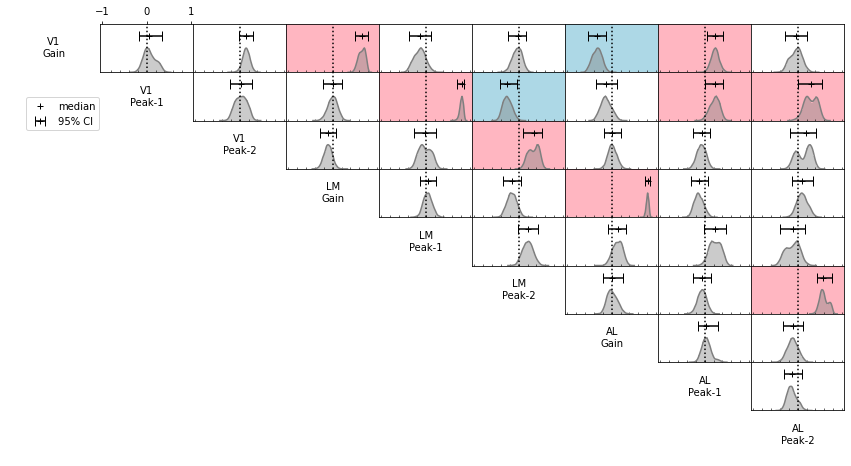

In [221]:
output_dir = 'D:/Brain_Network/Output/fig/'
partial_adj, partial_adj2, pval_mat = model.samples.plot_partial_correlation(1, 4, burn_in=2000, end=None, step=1,
    distribution_type='CI_hist', output_dir=output_dir)

In [ ]:
file_path = project_dir + 'Output/fig/V1_P2_AL_P2_Z_LM_P2_conditional_corr_embedded.pdf'
partial_index = [2,8, 5]
model.samples.plot_conditional_correlation_embedded(partial_index, burn_in=3000, end=None, step=10, file_path=file_path)

file_path = project_dir + 'Output/fig/V1_P2_LM_P2_Z_AL_P2_conditional_corr_embedded.pdf'
partial_index = [2,5, 8]
model.samples.plot_conditional_correlation_embedded(partial_index, burn_in=3000, end=None, step=10, file_path=file_path)

file_path = project_dir + 'Output/fig/LM_P2_AL_P2_Z_V1_P2_conditional_corr_embedded.pdf'
partial_index = [5,8, 2]
model.samples.plot_conditional_correlation_embedded(partial_index, burn_in=3000, end=None, step=10, file_path=file_path)

## $z$ membership, clustering

z_samples.shape (4919, 14, 191)
z_samples.shape (14, 191, 4919)
save figure: D:/Brain_Network/Output/fig/757216464_z.pdf


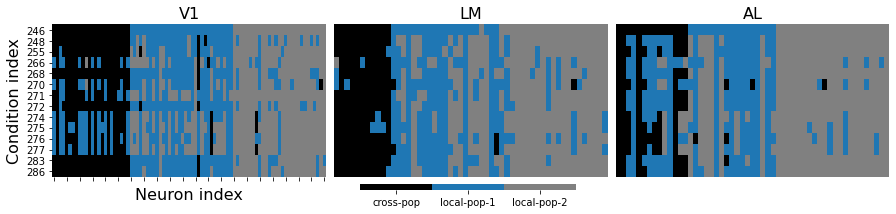

save figure: D:/Brain_Network/Output/fig/757216464_z_portion.pdf


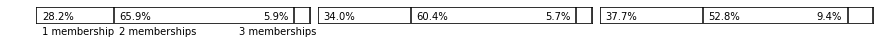

In [228]:
clist = list(range(len(condition_ids)))
output_dir = f'D:/Brain_Network/Output/fig/'
model.samples.plot_z(clist=clist, burn_in=3000, end=-1, step=1, sub_group_df_c=model.sub_group_df_c,
                     condition_ids=all_condition_ids, output_dir=output_dir)

z_samples.shape (14, 191, 4919)
save figure: D:/Brain_Network/Output/fig/757216464_z_cross_pop_weights.pdf


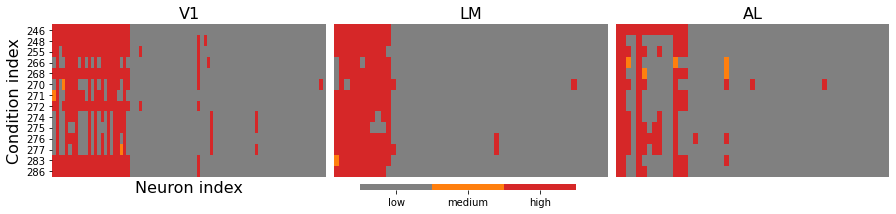

In [229]:
clist = list(range(len(condition_ids)))
output_dir = f'D:/Brain_Network/Output/fig/'
model.samples.plot_z_cross_pop_weight(clist=clist, burn_in=3000, end=-1, step=1, sub_group_df_c=model.sub_group_df_c,
        condition_ids=all_condition_ids, output_dir=output_dir)

z_samples.shape (14, 191, 984)
save figure: D:/Brain_Network/Output/fig/757216464_z_spatial_frequency.pdf


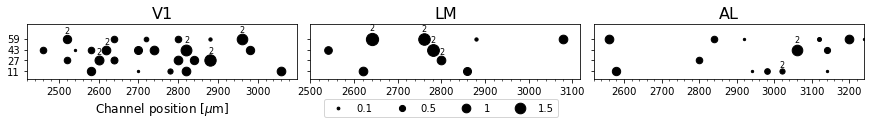

In [227]:
clist = list(range(len(condition_ids)))
output_figure_path = f'D:/Brain_Network/Output/fig/{session_id}_z_spatial_frequency.pdf'
model.plot_z_spatial_frequency(clist=clist, burn_in=3000, end=None, step=5, output_figure_path=output_figure_path)

z_samples.shape (14, 191, 4920)
save figure: D:/Brain_Network/Output/fig/757216464_z_samples_positions.pdf


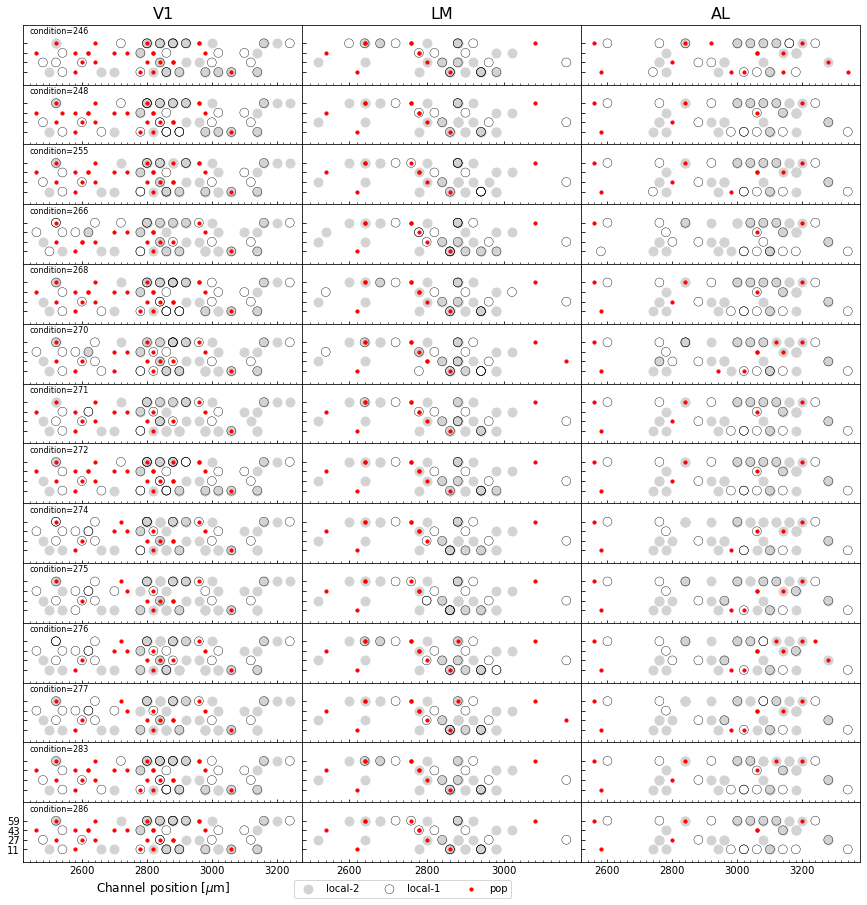

In [226]:
clist = list(range(len(condition_ids)))
output_figure_path = f'D:/Brain_Network/Output/fig/{session_id}_z_samples_positions.pdf'
model.plot_z_samples_location(clist=clist, burn_in=3000, end=None, step=1, output_figure_path=output_figure_path)

p_samples.shape: (7919, 3, 3, 14)
save figure: D:/Brain_Network/Output/fig/757216464_p_gac.pdf


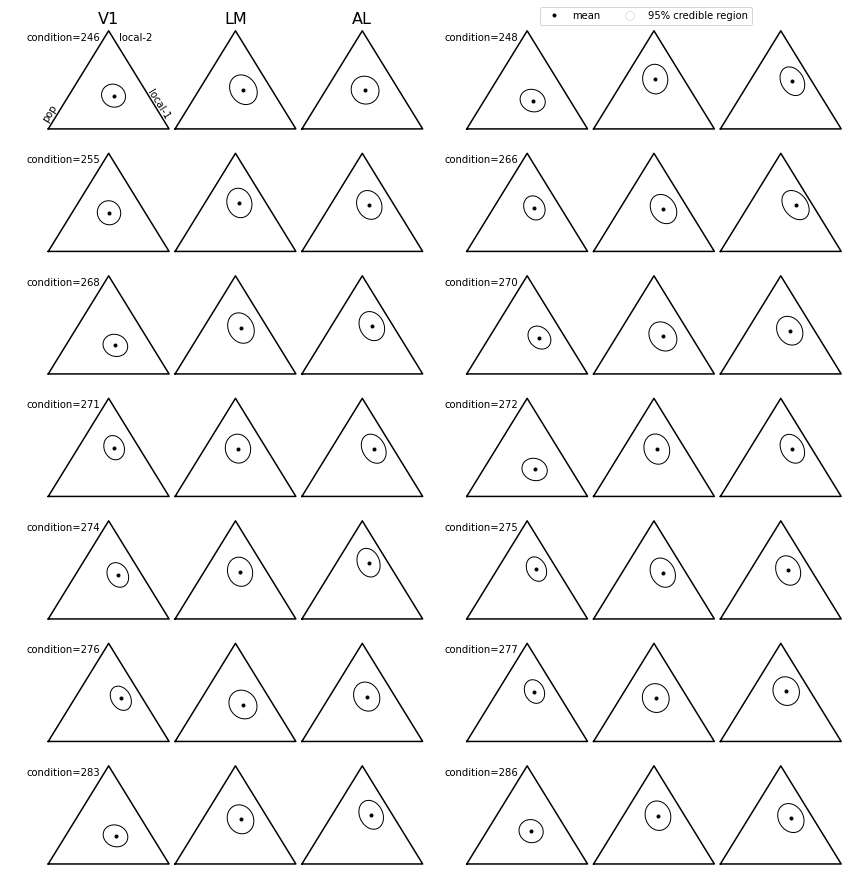

In [230]:
clist = list(range(len(condition_ids)))
output_figure_path = f'D:/Brain_Network/Output/fig/{session_id}_p_gac.pdf'
model.samples.plot_p_gac(clist, burn_in=0, end=-1, step=1, condition_ids=all_condition_ids,
                         output_figure_path=output_figure_path)